# EE613 - Hidden Markov Model - Exercise 2: Fitting Incomplete Data

In [1]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from mixture_model import *

np.set_printoptions(precision=4, suppress=True)
%load_ext autoreload
%autoreload 2

#### Load Data 

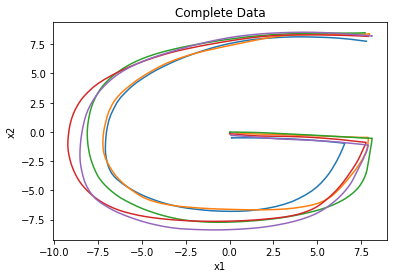

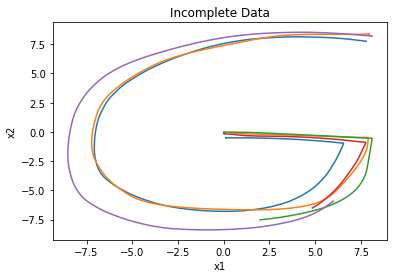

In [3]:
ROOT = '../python_data/2Dletters/'
n_samples = 5
raw_data = np.load(ROOT + 'G.npy')[:n_samples]
raw_data = raw_data.transpose([0,2,1])

#Remove some parts of the data, and re-sample to the same number of time steps
data = []
#complete data for samples 0,1
for i in range(2):
    data.append(raw_data[i]) 
    
#sample 2,3 starts from time step 100
for i in range(2,4):
    data.append(subsample(raw_data[i][100:200,:],200)) 

#sample 4 ends at time step 100    
for i in range(4,5):
    data.append(subsample(raw_data[i][:100,:],200))
    
data = np.array(data)
    
#plot complete data
for data_i in raw_data:
    plt.plot(data_i[:,0], data_i[:,1],'-')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Complete Data')

plt.show()
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Incomplete Data')


T = data.shape[1] #the number of timesteps for each trajectory
D = data.shape[2] #the number of dimensions

The data that we use here is the same as in Exercise 1, with one major difference: some of the data is not complete, i.e. some part of the data is removed (the beginning or the end).

### Question 1:

Train an HMM based on the given data above, and observe its performance as compared to Exercise 1. 

Note: for the purpose of this exercise, the incomplete data is re-sampled to have the same number of time steps as the complete data. This is not the limitation of HMM, but only for the convenience of the coding; it is slightly easier if all of them has the same number of time steps.

### Question 2: 

The data contains 5 samples of trajectories. For each sample, use the Viterbi algorithm to calculate the optimal sequence that correspond to the sample's trajectory. Does the result match the actual data? (the first and second sample are complete trajectories, while the rest either start from or stop at the middle of the letter).

hint: see __demo_HMM.ipynb__, the last section

In [4]:
hmm = HMM(D= 2, K=5, M = 5, N = T) #use 5 mixture components, 5 samples and 200 time steps

#### Manual Initialisation of the mixture components

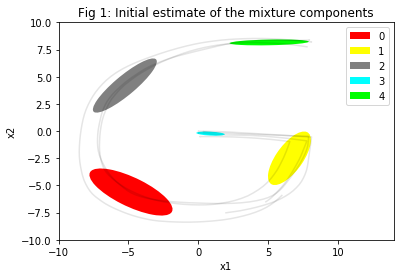

In [5]:
hmm.init_kmeans(data.reshape(-1,D))
#hmm.init_random(data.reshape(-1,D))
#hmm.init_kbins(data.reshape(-1,D))

#plot the mixture components
colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]
fig,ax = plt.subplots()
plot_GMM(hmm.means_, hmm.covariances_,ax,labels=['0','1','2','3','4','5'],colors=colors)
plt.axis([-10,14,-10,10])
plt.title('Fig 1: Initial estimate of the mixture components')
plt.legend(loc='east')

#plot data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-k', alpha=0.1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

#### Manual initialisation of the HMM's transition matrix 

In [6]:
hmm.init_HMM()
print('The initial transition matrix is:')
print hmm.Trans_

The initial transition matrix is:
[[ 0.2  0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2  0.2]
 [ 0.2  0.2  0.2  0.2  0.2]]


### Refining the HMM parameters using EM

Note: inside the 'fit' function, by default init_kmeans() and init_HMM() are called automatically. 

To change the initialisation of the mixture components inside the fit() function, change the parameter 'init_type' to :(OPTIONS) ['kmeans', 'random', 'kbins', None]. Setting it to None will keep the previously set values before calling the fit() function.

To change the initialisation of HMM's transition matrix, set the parameter 'init_trans' to the desired transition matrix. 

In [7]:
hmm.fit(data,init_type=None, n_init = 1,max_iter=50, init_trans = None)
clear_output()
'''
#random initialisation of the mixture components:
hmm.fit(data,init_type='random',n_init = 1,max_iter=50)
'''

'''
#random initialisation of the transition matrix:
Trans = np.random.rand(5,5)
Trans = Trans/np.sum(Trans,axis = 1)[:,None] #Normalise each row
hmm.fit(data,init_type='kmeans',n_init = 1,max_iter=50, init_trans=Trans)
'''

"\n#random initialisation of the transition matrix:\nTrans = np.random.rand(5,5)\nTrans = Trans/np.sum(Trans,axis = 1)[:,None] #Normalise each row\nhmm.fit(data,init_type='kmeans',n_init = 1,max_iter=50, init_trans=Trans)\n"

#### Examine the resulting parameters

Initial probability distribution of the mixture components:
[ 0.4  0.   0.   0.   0.6]

Transition matrix:
[[ 0.979   0.021   0.      0.      0.    ]
 [ 0.      0.9807  0.      0.0193  0.    ]
 [ 0.0187  0.      0.9813  0.      0.    ]
 [ 0.      0.      0.      1.      0.    ]
 [ 0.      0.      0.0216  0.      0.9784]]



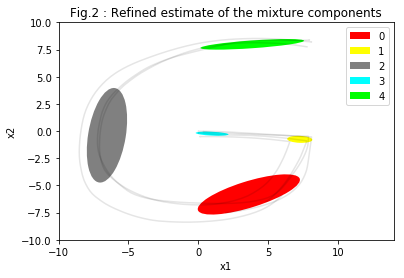

In [8]:
print('Initial probability distribution of the mixture components:')
print(hmm.weights_)
print('')

print('Transition matrix:')
print(hmm.Trans_)
print('')

#plot the mixture components
fig,ax = plt.subplots()
plot_GMM(hmm.means_, hmm.covariances_,ax,labels=['0','1','2','3','4','5'],colors=colors)
plt.axis([-10,14,-10,10])
plt.legend(loc='best')

#plot data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-k', alpha=0.1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Fig.2 : Refined estimate of the mixture components')
plt.show()

### Find the optimal sequence using Viterbi algorithms

Given a sequence of observations $\{x_t\}_{t=1}^{T}$, we can calculate the most probable sequence of mixture components that the observations belong to, using Viterbi algorithms.

In [11]:
data_index = 4 #select the sample index
opt_seq = hmm.viterbi(hmm.xs[2])
print('The optimal sequence for the given trajectory is:')
print(opt_seq)

The optimal sequence for the given trajectory is:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
